In [22]:
import numpy as np
from pwapprx import PWApprx
# measure time it takes
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from numba import jit
# Scipy sparse matrix solvers
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
# Scipy nulspace solver
from scipy.linalg import null_space
import pandas as pd
import sys

In [52]:
np.set_printoptions(linewidth=np.inf)
@jit
def calc_equal_portion(n, total_x_interval):
    p = (1/n) * total_x_interval
    return p

# returns the weight (the proportion) of x values of a function mapped by y values of another fuction   
@jit
def calc_weight(x_lb, x_ub, y_lb, y_ub):
    if x_lb > y_ub or y_lb > x_ub:
        return 0
    else:
        overlap_lb = x_lb if x_lb > y_lb else y_lb
        overlap_ub = x_ub if x_ub < y_ub else y_ub
        return (overlap_ub - overlap_lb) /(y_ub - y_lb)

def create_pwfunc_list(x_values, r):
    
    func_list = [0 for r_value in range(len(r))]

    for r_i, r_value in enumerate(r):
        # create the piecewise functions for that ra value
        func = PWApprx(x_values, r_value)
        func_list[r_i] = func

    return func_list   

def create_matrix_quadrant(x_values, func):
    # this method takes advantage of the mirrored and other properties of our data to make a matrix much faster
    
    n_equations = len(x_values) - 1
    
    y_values = func.get_y_values()
    matrix = np.zeros((n_equations, n_equations))

    col_index = 0 # keeps track of the current column
    row_index = 0 # keeps track of the current row

    weight = calc_weight(x_values[row_index],x_values[row_index+1], min(y_values[col_index],y_values[col_index+1]),max(y_values[col_index],y_values[col_index+1]))

    # Iterate through the rows 
    while weight != 0 and (row_index+1) < n_equations and col_index < (n_equations/2):

        while weight != 0 and col_index < (n_equations/2):
            min_col_index = col_index
            matrix[row_index][col_index] = weight
            matrix[row_index][(n_equations-1)-col_index] = weight # the matrix is mirrored so this is also true
            col_index += 1
            weight = calc_weight(x_values[row_index],x_values[row_index+1], y_values[col_index],y_values[col_index+1])
#             print(row_index, col_index, weight,"inner")

        col_index = min_col_index
        row_index += 1
        weight = calc_weight(x_values[row_index],x_values[row_index+1], y_values[col_index],y_values[col_index+1])
    
    while col_index < (n_equations/2):
#         print(row_index, col_index, weight)
        matrix[row_index][col_index] = weight
        matrix[row_index][(n_equations-1)-col_index] = weight
        col_index += 1
        weight = calc_weight(x_values[row_index],x_values[row_index+1], y_values[col_index],y_values[col_index+1])
    
#     if col_index < (n_equations/2)-1:
#         col_index += 1
#         weight = calc_weight(x_values[row_index],x_values[row_index+1], y_values[col_index],y_values[col_index+1])
#         print(x_values[row_index],x_values[row_index+1],y_values[col_index],y_values[col_index+1])
#         print(row_index, col_index, weight, "+1")
#         matrix[row_index][col_index] = weight
#         matrix[row_index][(n_equations-1)-col_index] = weight
    
#     col_index = n_equations//2
#     weight = calc_weight(x_values[row_index],x_values[row_index+1], y_values[col_index],y_values[col_index+1])
    
    
#     matrix[row_index][col_index-1] = weight
#     matrix[row_index][col_index] = weight # the matrix is mirrored so this is also true
    
    return matrix

def make_true_matrix(     ra,
                     rb,
                     n_points = 5, # integer number of (internal) points used to construct a linear apprx, this should be odd
                     savefile = False, # save a csv file of the matrix
                     print_to_log = False
                    ):   
        
    start = time.time()
    
    x_values = np.round(np.linspace(0, 1, n_points+2), 3) # values of x on the curve that will be used to create the approximation
    
    total_x_interval = np.amax(x_values) - np.amin(x_values)
    
    # create functions for linear approximation
        
    func_a = PWApprx(x_values, ra)
    func_b = PWApprx(x_values, rb)

    n_equations = len(x_values)-1
    
    zeros = np.zeros((n_equations,n_equations))
    for z_i, z in enumerate(zeros):
        z[z_i] = -1
    
    p = [(calc_equal_portion(n_equations, total_x_interval)/2) for i in range(n_equations * 2)]
    ans = np.zeros(len(p))
    ans[-1] = 1

    y_values_b = func_b.get_y_values()
    top_right_square = []

    for i in range(len(x_values)):
        if i != 0:      
            w_i = []
            for j in range(len(x_values)):
                if j != 0:  
                    # Top Right Square
                    weight = calc_weight(x_values[i-1],x_values[i], min(y_values_b[j-1],y_values_b[j]),max(y_values_b[j-1],y_values_b[j]))
                    w_i.append(weight)

            top_right_square.append(w_i)

    # needed to compute lyapunov exponent
    slopes_b = func_b.get_slope_list()

    top = np.concatenate((zeros, top_right_square), axis = 1)

    y_values_a = func_a.get_y_values()
    bottom_left_square = []

    for i in range(len(x_values)):
        if i != 0:      
            w_i = []
            for j in range(len(x_values)):
                if j != 0:  
                    # Bottom Left Square
                    weight = calc_weight(x_values[i-1],x_values[i], min(y_values_a[j-1],y_values_a[j]),max(y_values_a[j-1],y_values_a[j]))
                    w_i.append(weight) 
            bottom_left_square.append(w_i)

    bottom = np.concatenate((bottom_left_square, zeros), axis = 1)

    matrix = np.concatenate((top, bottom))
#     matrix[-1] = p

    slopes_a = func_a.get_slope_list()
    slopes = slopes_a + slopes_b
    
    try:
        solution = np.linalg.solve(matrix, ans)
        
        lyapunov_ex = np.sum(p * solution * np.log(np.abs(slopes)))
    except:
        lyapunov_ex = "Singularity"
        solution = "Singularity"
    
    if savefile:
        pd.DataFrame(matrix).to_csv("good_matrix.csv", header=None, index=None)
    
    if print_to_log:
        print('matrix:')
        print((matrix))
        print(f'ra = {ra} rb = {rb}')
        print(f'slopes: {repr(slopes)}')
        print(f'lyapunov exponent = {lyapunov_ex}')
        print('solution:')
        print(solution)

In [53]:
def lyapunov_fractal_csc(
                    ra,
                    rb,
                    x_values,
                    func_list_a,
                    func_list_b
                    ):

    lyapunov_grid = []
    
    total_x_interval = np.amax(x_values) - np.amin(x_values)
    
    # create functions for linear approximation 
        
    n_equations = len(x_values)-1
    
    zeros = np.zeros((n_equations,n_equations))
    for z_i, z in enumerate(zeros):
        z[z_i] = -1
    
    p = [(calc_equal_portion(n_equations, total_x_interval)/2) for i in range(n_equations * 2)]
    ans = np.zeros(len(p))
    ans[-1] = 1
    
    right_csc_matrices = []
    
    def lyapunov_from_sparse_matrix(sparse_matrix, slopes):
        # sparse matrix is a matrix in csc or csr form
        
        solution = cg(sparse_matrix, ans)
    
        return np.sum(p * solution * np.log(np.abs(slopes)))
    
#     def lyapunov_from_sparse_matrix(sparse_matrix, slopes):
#         # sparse matrix is a matrix in csc or csr form
        
#         solution = spsolve(sparse_matrix, ans)
    
#         return np.sum(p * solution * np.log(np.abs(slopes)))
    
    # counts the number of times a singular matrix is encountered
    singularities = 0
    # counts the number of times a lyap exponent is far below the normal, possibly caused by an approach to negative infinity in the log
    negative_outliers = 0
    
    # Calc Lyapunov using CSC Matrices
    # Info about CSC form
    # https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_column_(CSC_or_CCS)
    # https://scipy-lectures.org/advanced/scipy_sparse/csc_matrix.html
    
    # mirroring csc WIP
    
#     def create_left_csc_matrix(y_values):
        
#         # For each column the left side of the matrix will be the same, the change in the 
#         left_data = []
#         left_indices = []
#         left_indptrs = []
#         left_indptr = 0 # index pointer
#         left_indptrs.append(left_indptr)
        
#         # mirror data takes advantage of the places of symmetry in our matrix so that less iteration is required 
#         mirror_data = []
#         mirror_indices = []
#         mirror_lengths = []
#         mirror_indptrs = []
        
#         # Left Half of Matrix
#         for i in range(int(n_equations/2)):
#             # Columns  
#             # stores the data in the current column of the csc matrix
#             col_data = []
#             col_indices = []

#             # Add the diagonal of negative 1s to the top half of the left side
#             col_data.append(-1) # the data array holds the nonzero values
#             col_indices.append(i) # row index
#             left_indptr = left_indptr + 1 # each time we add a new row index add on to the index pointer signifying another entry in that column

#             # The way our data is structured after seeing the values the rest of the row except for the last column will be zero
#             seen_non_zero = False

#             for j in range(n_equations):
#                 # Rows
#                 if j != n_equations:  
#                     weight = calc_weight(x_values[j],x_values[j+1], y_values[i],y_values[i+1])
#                     # Add non zero weights to the row
#                     if weight != 0:
#                         col_data.append(weight)
#                         col_indices.append(j + n_equations)
#                         left_indptr = left_indptr + 1
#                         seen_non_zero = True
#                     elif seen_non_zero:
#                         # if zero is seen after not seeing zero
#                         break
                
#             # append the proportions to the last row
#             col_data.append(p[i-1])
#             col_indices.append((2 * n_equations))
#             left_indptr = left_indptr + 1
                
#             # at the end of the column assign the column to both the standard and the mirror data
#             left_data.append(col_data)
#             left_indices.append(col_indices) 
#             col_indices[0] = (n_equations) - col_indices[0] 
#             mirror_indices.append(col_indices)

#             left_indptrs.append(left_indptr) # at the end of the column appened the index pointer to the list of pointers

                
#         # mirror data is flipped version of left_data
#         mirror_data = np.flip(left_data)
#         # mirror indices 
#         mirror_indices = np.flip(mirror_indices)
# #         print(len(left_indices), len(mirror_indices))
        
        
#         # final data
#         left_data = np.concatenate((left_data, mirror_data))
#         left_indices = np.concatenate((left_indices, mirror_indices))
#         flat_left_data = [item for sublist in left_data for item in sublist] 
#         flat_left_indices = [item for sublist in left_indices for item in sublist]
        
#         for col in mirror_data: 
#             left_indptrs.append(len(col) + left_indptrs[-1])
        
# #         print(left_data)
# #         print(left_indices)
# #         print(left_indptrs)
        
        
# #         print(len(left_data))
# #         print(len(left_indices))
# #         print(len(flat_left_data))
# #         print(len(flat_left_indices))
    
#         return (flat_left_data, flat_left_indices, left_indptrs)

    def create_left_csc_matrix(y_values):
        
        # For each column the left side of the matrix will be the same, the change in the 
        left_data = []
        left_indices = []
        left_indptrs = []
        left_indptr = 0 # index pointer
        left_indptrs.append(left_indptr)
        
        # mirror data takes advantage of the places of symmetry in our matrix so that less iteration is required 
        mirror_data = []
        mirror_indices = []
        mirror_lengths = []
        mirror_indptrs = []
        
                
        # Left Half of Matrix
        for i in range(len(x_values)):
            # Columns
            if i != 0:
                
                # Add the diagonal of negative 1s to the top half of the left side
                left_data.append(-1) # the data array holds the nonzero values
                left_indices.append(i - 1) # row index
                left_indptr = left_indptr + 1 # each time we add a new row index add on to the index pointer signifying another entry in that column
                
                # The way our data is structured after seeing the values the rest of the row except for the last column will be zero
                seen_non_zero = False
                
                for j in range(len(x_values)):
                    # Rows
                    if j != 0 and j != n_equations:  
                        weight = calc_weight(x_values[j-1],x_values[j], min(y_values[i-1],y_values[i]),max(y_values[i-1],y_values[i]))
                        # Add non zero weights to the row
                        
                        if weight != 0:
                            left_data.append(weight)
                            left_indices.append(j + n_equations - 1)
                            left_indptr = left_indptr + 1
                            seen_non_zero = True
                        elif seen_non_zero:
                            # if zero is seen after not seeing zero
                            break
                
                # append the proportions to the last row
                left_data.append(p[i-1])
                left_indices.append((2 * n_equations) - 1)
                left_indptr = left_indptr + 1
                
                left_indptrs.append(left_indptr) # at the end of the column appened the index pointer to the list of pointers

                    

        return (left_data, left_indices, left_indptrs)
        
    def create_right_csc_matrix(y_values_b):
        # The create right matrix func is very similiar but the order of some things are switched around
        # The negatives 1s on the diagonal must be added after the weights are
        
        right_data = []
        right_indices = []
        right_indptrs = []
        right_indptr = 0 # index pointer
        right_indptrs.append(right_indptr)
        
        # Right Half of Matrix
        for i in range(len(x_values)):
            # Columns
            if i != 0: 
                # The way our data is structured after seeing the values the rest of the row except for the last column will be zero
                seen_non_zero = False
                
                for j in range(len(x_values)):
                    # Rows
                    if j != 0:  
                        weight = calc_weight(x_values[j-1],x_values[j], min(y_values_b[i-1],y_values_b[i]),max(y_values_b[i-1],y_values_b[i]))
                        if weight != 0:
                            right_data.append(weight)
                            right_indices.append(j - 1)
                            right_indptr = right_indptr + 1
                            seen_non_zero = True
                        elif seen_non_zero:
                            # if zero is seen after not seeing zero
                            break

                if i < n_equations:
                    right_data.append(-1)
                    right_indices.append(i + n_equations - 1)
                    right_indptr = right_indptr + 1

                right_data.append(p[i+n_equations - 1])
                right_indices.append((n_equations*2)-1)
                right_indptr = right_indptr + 1

                right_indptrs.append(right_indptr)
                
        return (right_data, right_indices, right_indptrs)


    def fuse_LR_matrices(left_csc_matrix, right_csc_matrix):
        # concatenate data and indices lists
        data =  np.concatenate((left_csc_matrix[0], right_csc_matrix[0]))
#         print(len(data), (len(left_csc_matrix[0]) + len(right_csc_matrix[0])))
        indices = np.concatenate((left_csc_matrix[1], right_csc_matrix[1]))
        # get the last indptr of the left array and add it to the elemnts of the right array because they come after
        adjusted_right_indptrs = np.add(right_csc_matrix[2], left_csc_matrix[2][-1])
        # remove the first element so it is not duplicated
#         print(adjusted_right_indptrs)
        adjusted_right_indptrs = np.delete(adjusted_right_indptrs, 0)
        indptrs = np.concatenate((left_csc_matrix[2], adjusted_right_indptrs))
        
        return (data, indices, indptrs)
    
    
    for a_i, a in enumerate(ra):
        
#         if a_i % v_precent_interval == 0:
#             print("a = {}, {:2.2%} done {} seconds elapsed".format(a, (a_i/steps), (time.time() - start)))
        
        lyapunov_row = []
        y_values_a = func_list_a[a_i].get_y_values()
        slopes_a = func_list_a[a_i].get_slope_list()
        
        left_csc_matrix = create_left_csc_matrix(y_values_a)
        
        for b_i, b in enumerate(rb):
            
            y_values_b = func_list_b[b_i].get_y_values()
            slopes_b = func_list_a[b_i].get_slope_list()
            
            if a_i == 0:           
                right_csc_matrices.append(create_right_csc_matrix(y_values_b))
                
            full_matrix_tuple = fuse_LR_matrices(left_csc_matrix, right_csc_matrices[b_i])
            
            full_matrix = csc_matrix(full_matrix_tuple, shape=(2 * n_equations, 2 * n_equations))
            
            slopes = slopes_a + slopes_b
            
#             lyapunov_ex = lyapunov_from_sparse_matrix(sparse_matrix, slopes)
            
            try:
                lyapunov_ex = lyapunov_from_sparse_matrix(full_matrix, slopes)
                
                if lyapunov_ex < -4:
#                     print(a, b)
#                     print(matrix)
                    negative_outliers = negative_outliers + 1
                    lyapunov_ex = -4
        

            except:
#                 print(a, b)
#                 print(matrix)
                singularities = singularities + 1
                
#                 print(lyapunov_ex)
                lyapunov_ex = 0
    
            lyapunov_row.append(lyapunov_ex)
    
        lyapunov_grid.append(lyapunov_row)
    
    print("Singularities: " + str(singularities))
    print("Negative Outliers: " + str(negative_outliers))
    
    return lyapunov_grid


In [64]:
def lyapunov_fractal_matrix(
                    solver_type, # linsolve, nullspace
                    ra,
                    rb,
                    x_values,
                    func_list_a,
                    func_list_b
                    ):
    
    start = time.time()
        
    lyapunov_grid = []
    
    n_equations = len(x_values)-1
    
    zeros = np.zeros((n_equations,n_equations))
    for z_i, z in enumerate(zeros):
        z[z_i] = -1
    
    if solver_type == 'linsolver':
        total_x_interval = np.amax(x_values) - np.amin(x_values)
        p = [(calc_equal_portion(n_equations, total_x_interval)/2) for i in range(n_equations * 2)]
        
        ans = np.zeros(len(p))
        ans[-1] = 1
        
        # counts the number of times a singular matrix is encountered
        singularities = 0
        # counts the number of times a lyap exponent is far below the normal, possibly caused by an approach to negative infinity in the log
        negative_outliers = 0
        
        def lyapunov_from_matrix(matrix, slopes):
            matrix[-1] = p
            
            try:
                solution = np.linalg.solve(matrix, ans)
                return np.sum(p * solution * np.log(np.abs(slopes)))
                
#                 if lyapunov_ex < -4:
# #                     print(a, b)
# #                     print(matrix)
#                     negative_outliers = negative_outliers + 1
#                     lyapunov_ex = -4
            except:
                
                return 0
            
    elif solver_type == 'nullspace':
        def lyapunov_from_matrix(matrix, slopes):
            ns = null_space(matrix)
#             print(np.shape(ns))
            ns_transpose = ns.T
            
            sum_weight = np.sum(ns_transpose[0])
            solution = np.divide(ns_transpose[0], sum_weight)
            # now the sum of s will equal 1
            
            return np.dot(solution, np.log(np.abs(slopes)))         
    
    # Calc Lyapunoc using Regular Matrices
    bottoms = []
    tops = []
    
    for b_i, b in enumerate(rb):
        
#         top_right_square = create_matrix_quadrant(x_values, func_list_b[b_i])     
        
        if b_i % (max(int(len(rb)/20), 1)) == 0:
            print("b = {}, {:2.2%} done".format(b, (b_i/len(rb))))
        
        lyapunov_row = []
        
        # needed to compute lyapunov exponent
        slopes_b = func_list_b[b_i].get_slope_list()
        
#         top = np.concatenate((zeros, top_right_square), axis = 1)
        
        for a_i, a in enumerate(ra):
            
            if b_i == 0:
                quadrant_matrix = create_matrix_quadrant(x_values, func_list_a[a_i])   
                
                bottom = np.concatenate((quadrant_matrix, zeros), axis = 1)
                top = np.concatenate((zeros, quadrant_matrix), axis = 1)
                bottoms.append(bottom)
                tops.append(top)
            
            matrix = np.concatenate((tops[b_i], bottoms[a_i]))
            
            slopes_a = func_list_a[a_i].get_slope_list()
            slopes = slopes_a + slopes_b    
            
            try:
                lyapunov_ex = lyapunov_from_matrix(matrix, slopes)
            except:
                print(a, b)
                pd.DataFrame(matrix).to_csv("bad_matrix.csv", header=None, index=None)
                make_true_matrix(a, b, len(x_values)-2, savefile = True)  
                sys.exit(0)
            
            lyapunov_row.append(lyapunov_ex)
            
        lyapunov_grid.append(lyapunov_row)
    
    if solver_type == "linsolver":
        print("Singularities: " + str(singularities))
        print("Negative Outliers: " + str(negative_outliers))
    
    return lyapunov_grid

In [65]:
def lyapunov_fractal_invariant(
         solver_type, # linsolver, csc, nullspace 
         # all fractals
         r_lb = 2, r_ub = 4, # lower and upper bounds of the A and B axis
         steps = 500, # the number of values between each upper and lower bound
         # for linear fractals only
         n_points = 5, # integer number of (internal) points used to construct a linear apprx, this should be odd
         # for iterative fractals only
#          n_warmups = 1200, # number of warmup iterations
#          n_iter = 120, # number of iterations used to compute the lyapunov exponents
#          x_0 = 0.5, # starting value of x
         # Save/display options
         showfractal = True, # whether or not to display the fractal
         savepng = False, # save a png of the fractal image
         savefile = False, # save a binary file with the lyapunov data from the fractal    
                    ):
    
    if n_points % 2 == 0:
        n_points = n_points + 1
        print(f"n_points cannot be even, changed n_points to {n_points}")
    
    a_lb, a_ub = r_lb, r_ub
    b_lb, b_ub = r_lb, r_ub
    
    ra = np.linspace(a_lb, a_ub, steps)
    rb = np.linspace(b_lb, b_ub, steps)
    
    x_values = np.round(np.linspace(0, 1, n_points+2), 3) # values of x on the curve that will be used to create the approximation
    
    # create functions for linear approximation     
    func_list_a  = create_pwfunc_list(x_values, ra)
    
    if not a_lb == b_lb and a_ub == b_ub:
        func_list_b = create_pwfunc_list(x_values, rb)     
    else:
        func_list_b = func_list_a
        
    start = time.time()
    
    if solver_type == 'linsolver' or solver_type == 'nullspace':
        lyapunov_grid = lyapunov_fractal_matrix(solver_type, ra, rb, x_values, func_list_a, func_list_b)
    elif solver_type == 'csc':
        lyapunov_grid = lyapunov_fractal_csc(ra, rb, x_values, func_list_a, func_list_b)
    
    end = time.time()
    
    filename = ("invariant_fractal " + solver_type + " n_points= " + str(n_points) + " steps=" + str(steps))
    
    if savefile:
        f = open(filename + ".dat", "wb")
        lyapunov_grid = np.ascontiguousarray(lyapunov_grid)
        f.write(lyapunov_grid)
        f.close()
    
    # plot information
    
    fig, ax = plt.subplots(figsize=(10, 9))
    
    fig.patch.set_facecolor('white')
    
#     lya_cmap = copy.copy(mpl.cm.get_cmap('viridis'))
    lya_cmap = copy.copy(mpl.cm.get_cmap('jet'))
    lya_cmap.set_over('black')
#     lya_cmap.set_under('white')
#     lya_cmap.set_bad('black')
    
    plt.imshow(lyapunov_grid , cmap = lya_cmap, origin = 'lower', vmax = 0, vmin = -4)
    
    plt.colorbar()
    plt.suptitle("Lyapunov Logistic Fractal - Linear Apprx")
    plt.title("steps = " + str(steps) + " n_points = " + str(n_points))  
    
    xticks = np.arange(a_lb, a_ub, .2)
    yticks = np.arange(b_lb, b_ub, .2)
    
    plt.xlabel("A")  
    plt.ylabel("B") 
    
    plt.xticks([])
    plt.yticks([])
    
    if(savepng):
        plt.savefig(filename + ".png")
    
    plt.show()

    print("This took", end - start, "seconds to execute")
    
    

b = 2.0, 0.00% done
b = 2.0816326530612246, 4.00% done
b = 2.163265306122449, 8.00% done
b = 2.2448979591836733, 12.00% done
b = 2.326530612244898, 16.00% done
b = 2.4081632653061225, 20.00% done
b = 2.489795918367347, 24.00% done
b = 2.571428571428571, 28.00% done
b = 2.6530612244897958, 32.00% done
b = 2.7346938775510203, 36.00% done
b = 2.816326530612245, 40.00% done
b = 2.8979591836734695, 44.00% done
b = 2.979591836734694, 48.00% done
b = 3.061224489795918, 52.00% done
b = 3.142857142857143, 56.00% done
b = 3.224489795918367, 60.00% done
b = 3.3061224489795915, 64.00% done
b = 3.387755102040816, 68.00% done
b = 3.4693877551020407, 72.00% done
b = 3.5510204081632653, 76.00% done
b = 3.63265306122449, 80.00% done
b = 3.7142857142857144, 84.00% done
b = 3.7959183673469385, 88.00% done
b = 3.877551020408163, 92.00% done
b = 3.9591836734693877, 96.00% done


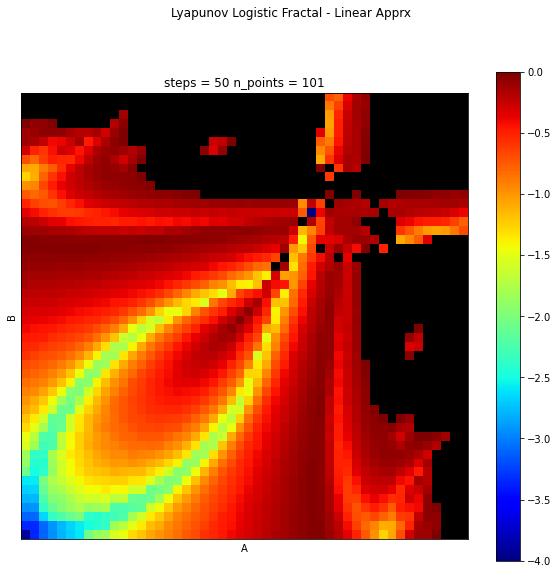

This took 15.0297691822052 seconds to execute


In [66]:
fixed_steps = 50
fixed_points = 101
# lyapunov_fractal_invariant('linsolver', n_points = fixed_points, steps = fixed_steps)
lyapunov_fractal_invariant('nullspace', n_points = fixed_points, steps = fixed_steps)
# lyapunov_fractal_invariant('csc', n_points = fixed_points, steps = fixed_steps)